# leafGAN_CNN

Train a CNN to predict the effective modulus of structures generated by StyleGAN based on simulation data

Sabrina Shen, MIT, 2022

Shen, S.C., Buehler, M.J. Nature-inspired Architected materials using unsupervised deep learning. Accepted (2022).

In [1]:
import os 
import glob 
import PIL
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi -L

GPU 0: Quadro RTX 5000 (UUID: GPU-78162963-0a30-bd79-76cb-1dd6b2a4206c)


In [3]:
#Import image files
files = glob.glob('MD/images/*')

MD/images\0030_smoothed.png


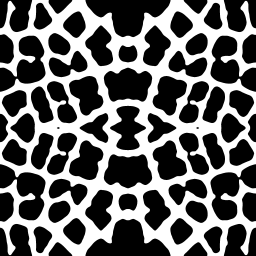

In [4]:
# Visualize images 
idx = 30
img = Image.open(files[idx])
print(files[idx])
img

In [7]:
data

,unit,density,mod_norm,Filename
0,0,0.449097,0.091720,0000_smoothed.png
1,1,0.239075,0.071529,0001_smoothed.png
2,2,0.334167,0.085433,0002_smoothed.png
3,3,0.825378,0.411382,0003_smoothed.png
4,4,0.426392,0.079227,0004_smoothed.png
...,...,...,...,...
4995,4995,0.378174,0.083176,4995_smoothed.png
4996,4996,0.296326,0.132388,4996_smoothed.png
4997,4997,0.385742,0.093868,4997_smoothed.png
4998,4998,0.363464,0.106047,4998_smoothed.png


In [22]:
#Input labels (modulus)
data=pd.read_csv("./MD/data_v3.csv")
labels=np.array(data["mod_norm"])*100

In [23]:
labels

array([ 9.171951 ,  7.1529216,  8.5432738, ...,  9.3867925, 10.6046693,
        9.4096553])

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [25]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        
        self.paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
  
        # read images given file path 
        file = self.paths[idx]
        img = Image.open(file)

        # transform images 
        img_size = 256
        self.transform = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()])
        img = self.transform(img)
        
        # get label
        label_idx = int(file[10:14]) 
        #label=torch.LongTensor(labels[label_idx])
        label=torch.FloatTensor([labels[label_idx]])
        
        return img, label

In [26]:
from sklearn.model_selection import train_test_split
temp, test = train_test_split(files, test_size=0.2)
train, val = train_test_split(temp, test_size=0.125)

#Build dataset 
traindata = ImageDataset(image_paths=train)
valdata = ImageDataset(image_paths=val)
testdata = ImageDataset(image_paths=test)

# Build dataloader 
batchsize = 4
train_loader = DataLoader(dataset=traindata,batch_size=batchsize,shuffle=True)
val_loader = DataLoader(dataset=valdata,batch_size=batchsize,shuffle=True)
test_loader = DataLoader(dataset=testdata,batch_size=batchsize,shuffle=True)


0 torch.Size([1, 256, 256]) tensor([31.1060])
1 torch.Size([1, 256, 256]) tensor([8.7577])
2 torch.Size([1, 256, 256]) tensor([0.])
3 torch.Size([1, 256, 256]) tensor([5.0436])


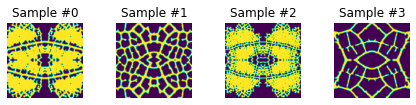

In [27]:
#check dataloaders
fig = plt.figure()


for i in range(len(testdata)):
    img, label = testdata[i]

    print(i, img.shape, label)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(img.permute(1,2,0))

    if i == 3:
        plt.show()
        break
        
img, label = next(iter(train_loader))

In [28]:
#Simple CNN
# import necessary packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch import nn 

In [29]:
class leaf_cnn(Module):
    def __init__(self):
        
        # call the parent constructor
        super(leaf_cnn, self).__init__()
        
        # initialize first set of CONV => RELU => POOL layers
        self.conv1 = Conv2d(1, 32, 5, stride=1, padding=2) #(in channels, out channels, kernel size, stride, padding)
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) #output is 128 x 128
        
        # initialize second set of CONV => RELU => POOL layers
        self.conv2 = Conv2d(32, 64, 5, stride=1, padding=2)
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) #output is 64x64
        
        # initialize third set of CONV => RELU => POOL layers
        self.conv3 = Conv2d(64, 128, 5, stride=1, padding=2)
        self.relu3 = ReLU()
        self.maxpool3 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) #output is 3x32
        
        # initialize fourth set of CONV => RELU => POOL layers
        self.conv4 = Conv2d(128, 256, 5, stride=1, padding=2)
        self.relu7 = ReLU()
        self.maxpool4 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) #output is 16x16
        
        #fifth layer
        #self.conv5 = Conv2d(256, 512, 5, stride=1, padding=2)
        #self.relu8 = ReLU()
        #self.maxpool5 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) #output is 8x8
        
        # initialize first (and only) set of FC => RELU layers
        self.fc1 = Linear(in_features=65536, out_features=500)
        self.relu4 = ReLU()
        # second FC
        self.fc2 = Linear(in_features=500, out_features=200)
        self.relu5 = ReLU()
        #regressor
        self.fc3 = Linear(in_features=200, out_features=1)
        self.relu6 = ReLU()
        
    def forward(self, x):
        # pass the input through our first set of CONV => RELU =>POOL layers
        x = self.maxpool1(self.relu1(self.conv1(x)))
        # pass the output from the previous layer through the second set of CONV => RELU => POOL layers
        x = self.maxpool2(self.relu2(self.conv2(x)))
        # pass the output from the previous layer through the second set of CONV => RELU => POOL layers
        x = self.maxpool3(self.relu3(self.conv3(x)))
        # 4th conv
        x=self.maxpool4(self.relu7(self.conv4(x)))
        # 5th conv
        #x=self.maxpool5(self.relu8(self.conv5(x)))        
        # flatten the output from the previous layer and pass it through our only set of FC => RELU layers
        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu4(x)
        # FC 2
        x = self.fc2(x)
        x = self.relu5(x)
        # Regressor
        x = self.fc3(x)
        output = self.relu6(x)
        # return the output predictions
        return output

torch.manual_seed(83)
model=leaf_cnn()
model.to(device)

leaf_cnn(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu7): ReLU()
  (maxpool4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=500, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=500, out_features=200, bias=True)
  (relu5): ReLU()
  (fc3): Linear(in_features=200, out_features=1, b

In [30]:
#Training algorithms

from torch import optim
loss_fn = nn.MSELoss()
#optimizer = optim.Adam(list(model.classifier.parameters()), lr=.001)
optimizer = optim.Adam(model.parameters(), lr=.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train(model, dataloader, optimizer, device):

    batch_loss = []
      
    for batch in dataloader: 
        model.train() # Set model to training mode    
        img, label = batch
        #label = torch.reshape(label, (4,))
        img = img.to(device)
        label = label.to(device)
        
        # train your model on each batch here 
        pred = model(img)
        #pred = model.classifier(pred)
        loss = loss_fn(pred, label)
        batch_loss=np.append(batch_loss, [loss.item()])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.mean(batch_loss)

def validate(model, dataloader, device):
    
    val_loss = []
    model.eval() # Set model to evaluation mode 
    with torch.no_grad():    
        for batch in dataloader:
            img, label = batch
            img = img.to(device)
            #label = torch.reshape(label, (4,))
            label = label.to(device)
            
            # validate your model on each batch here 
            pred = model(img)
            #pred = model.classifier(pred)
            loss = loss_fn(pred, label)
            val_loss=np.append(val_loss, [loss.item()])

    return np.mean(val_loss)

In [31]:
#Train Classifier
print("epoch", "train loss", "validation loss")

val_loss_curve = []
train_loss_curve = []

for epoch in range(100):
    
    # Compute train your model on training data
    epoch_loss = train(model, train_loader, optimizer,  device=0)
    
    # Validate your on validation data 
    val_loss = validate(model, val_loader, device=0) 
    
    # Record train and loss performance 
    train_loss_curve.append(epoch_loss)
    val_loss_curve.append(val_loss)
    
    # The learning rate scheduler record the validation loss 
    #scheduler.step(val_loss)
    
    print(epoch, epoch_loss, val_loss)

epoch train loss validation loss
0 66.98076802437646 43.894513235807416
1 27.348469358478273 24.77731520366669
2 12.488040707758495 8.542444838941098
3 9.734093873008952 6.522003639549017
4 8.39894992263828 6.5680559733212
5 8.296466649747321 8.837620165526866
6 5.9354856545291845 5.189336408257485
7 6.2593117100356945 10.150702712953091
8 4.514747597995081 10.740468684375285
9 5.085319345942565 7.352023026317358
10 4.542526780692595 6.44227935731411
11 4.082421341022743 6.439062774509192
12 4.296042033609535 5.21626572561264
13 3.2345774250252872 4.743842135965824
14 2.6473050671613643 5.073005137957632
15 2.9713746952812987 5.320849922835827
16 1.9487902449205783 4.562346010804176
17 2.038042489327357 4.132297303974628
18 1.8795114091231622 3.693873952507973
19 1.6789366479728902 4.364954255500808
20 1.6585554805820408 4.1407759281694885
21 1.1066319283608692 4.3535539059638975
22 1.8416800571113292 4.19892930623889
23 1.2279198341837951 5.899647251218557
24 2.259974096075765 3.91661

In [42]:
#Plot losses
plt.plot(train_loss_curve, label='Training Loss')
plt.plot(val_loss_curve, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [33]:
model.eval()
with torch.no_grad():
  train_loss = validate(model, train_loader, device=0)
  test_loss = validate(model, test_loader, device=0)
    
print('train loss: ' + str(train_loss))
print('test loss: ' + str(test_loss))

train loss: 0.2012127062637758
test loss: 5.544580271981657


In [35]:
train_pred = torch.empty(0).to(device)
test_pred = torch.empty(0).to(device)
train_label = torch.empty(0).to(device)
test_label = torch.empty(0).to(device)

model.eval()
with torch.no_grad():
  for batch in test_loader:
    img, label = batch
    img = img.to(device)
    label = torch.reshape(label, (4,))
    label = label.to(device)
            
  # test your model on each batch here 
    pred = model(img)
    #pred = model.classifier(pred).argmax(dim=-1)
    test_pred = torch.cat((test_pred, pred))
    test_label = torch.cat((test_label, label))

In [34]:
#train_pred = torch.empty(0).to(device)
#test_pred = torch.empty(0).to(device)
#train_label = torch.empty(0).to(device)
#test_label = torch.empty(0).to(device)

model.eval()
with torch.no_grad():
  for batch in test_loader:
    img, label = batch
    img = img.to(device)
    label = torch.reshape(label, (4,))
    label = label.to(device)
            
  # test your model on each batch here 
    pred = model(img)
    #pred = model.classifier(pred).argmax(dim=-1)
    test_pred = torch.cat((test_pred, pred))
    test_label = torch.cat((test_label, label))

NameError: name 'test_pred' is not defined

0.9710058098081523


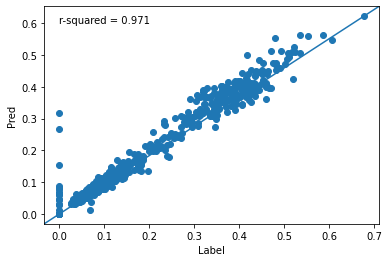

In [41]:
from sklearn.metrics import mean_squared_error, r2_score
r2=r2_score(test_label.cpu(),test_pred.cpu())
print(r2)

fig, ax = plt.subplots()

ax.scatter(test_label.cpu()/100, test_pred.cpu()/100)

ax.set_xlabel('Label')
ax.set_ylabel('Pred')
ax.plot([0,1],[0,1], transform=ax.transAxes)
ax.annotate("r-squared = {:.3f}".format(r2), (0, .60))
    
plt.show()
    
plt.close()

In [38]:
path='C:/Users/sabri/Desktop/LAMM/leaf_stylegan/GA/trained_models/4layer.pth'
torch.save(model.state_dict(), path)

#to load
#the_model = TheModelClass(*args, **kwargs)
#the_model.load_state_dict(torch.load(PATH))